# Tutorial: Boltzmann Machines

This shows how to train a Boltzmann machine, to sample from an observed probability distribution.

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 9, Tutorial (this is discussed in session 9)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use a Boltzmann machine to sample from an observed high-dimensional probability distribution (e.g. produce images that look similar to observed training images)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

from IPython.display import clear_output
from time import sleep

In [2]:
def BoltzmannStep(v,b,w):
    """
    Perform a single step of the Markov chain,
    going from visible units v to hidden units h,
    according to biases b and weights w.
    
    z_j = b_j + sum_i v_i w_ij
    
    and P(h_j=1|v) = 1/(exp(-z_j)+1)
    
    Note: you can go from h to v, by inserting
    instead of v the h, instead of b the a, and
    instead of w the transpose of w
    """
    batchsize=np.shape(v)[0]
    hidden_dim=np.shape(w)[1]
    z=b+np.dot(v,w)
    P=1/(np.exp(-z)+1)
    # now, the usual trick to obtain 0 or 1 according
    # to a given probability distribution:
    # just produce uniform (in [0,1]) random numbers and
    # check whether they are below the cutoff given by P
    p=np.random.uniform(size=[batchsize,hidden_dim])
    return(np.array(p<=P,dtype='int'))
    
def BoltzmannSequence(v,a,b,w,drop_h_prime=False):
    """
    Perform one sequence of steps v -> h -> v' -> h'
    of a Boltzmann machine, with the given
    weights w and biases a and b!
    
    All the arrays have a shape [batchsize,num_neurons]
    (where num_neurons is num_visible for v and
    num_hidden for h)
    
    You can set drop_h_prime to True if you want to
    use this routine to generate arbitrarily long sequences
    by calling it repeatedly (then don't use h')
    Returns: v,h,v',h'
    """
    h=BoltzmannStep(v,b,w)
    v_prime=BoltzmannStep(h,a,np.transpose(w))
    if not drop_h_prime:
        h_prime=BoltzmannStep(v_prime,b,w)
    else:
        h_prime=np.zeros(np.shape(h))
    return(v,h,v_prime,h_prime)

def trainStep(v,a,b,w):
    """
    Given a set of randomly selected training samples
    v (of shape [batchsize,num_neurons_visible]), 
    and given biases a,b and weights w: update
    those biases and weights according to the
    contrastive-divergence update rules:
    
    delta w_ij = eta ( <v_i h_j> - <v'_i h'_j> )
    delta a_i  = eta ( <v_i> - <v'_i>)
    delta b_j  = eta ( <h_j> - <h'_j>)
    
    Returns delta_a, delta_b, delta_w, but without the eta factor!
    It is up to you to update a,b,w!
    """
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w)
    return( np.average(v,axis=0)-np.average(v_prime,axis=0) ,
            np.average(h,axis=0)-np.average(h_prime,axis=0) ,
            np.average(v[:,:,None]*h[:,None,:],axis=0)-
               np.average(v_prime[:,:,None]*h_prime[:,None,:],axis=0) )


In [3]:
def produce_samples_random_segment(batchsize,num_visible,max_distance=3):
    """
    Produce 'batchsize' samples, of length num_visible.
    Returns array v of shape [batchsize,num_visible]
    
    This here: produces randomly placed segments of
    size 2*max_distance.
    """
    random_pos=num_visible*np.random.uniform(size=batchsize)
    j=np.arange(0,num_visible)
    
    return( np.array( np.abs(j[None,:]-random_pos[:,None])<=max_distance, dtype='int' ) )

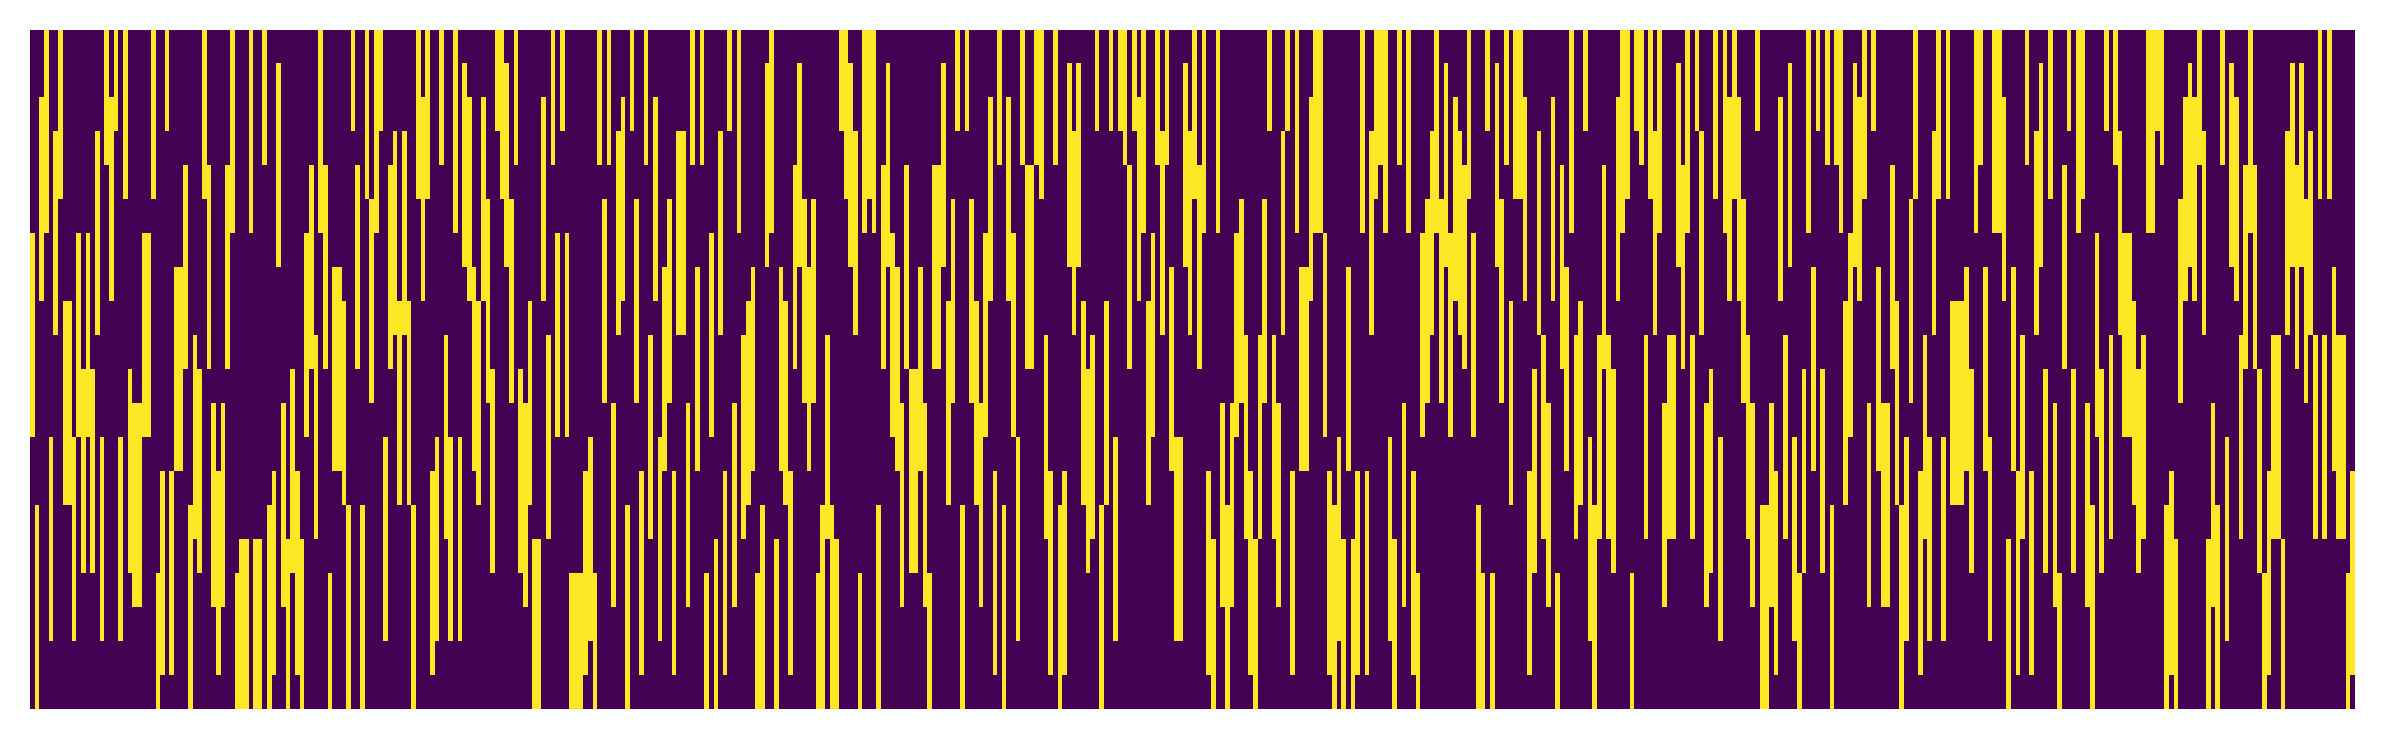

In [4]:
# Now: the training

num_visible=20
num_hidden=10
batchsize=50
eta=0.1
nsteps=500
skipsteps=10

a=np.random.randn(num_visible)
b=np.random.randn(num_hidden)
w=np.random.randn(num_visible,num_hidden)

test_samples=np.zeros([num_visible,nsteps])

for j in range(nsteps):
    v=produce_samples_random_segment(batchsize,num_visible)
    da,db,dw=trainStep(v,a,b,w)
    a+=eta*da
    b+=eta*db
    w+=eta*dw
    test_samples[:,j]=v[0,:]
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.figure(figsize=(10,3))
        plt.imshow(test_samples,origin='lower',aspect='auto',interpolation='none')
        plt.axis('off')
        plt.show()

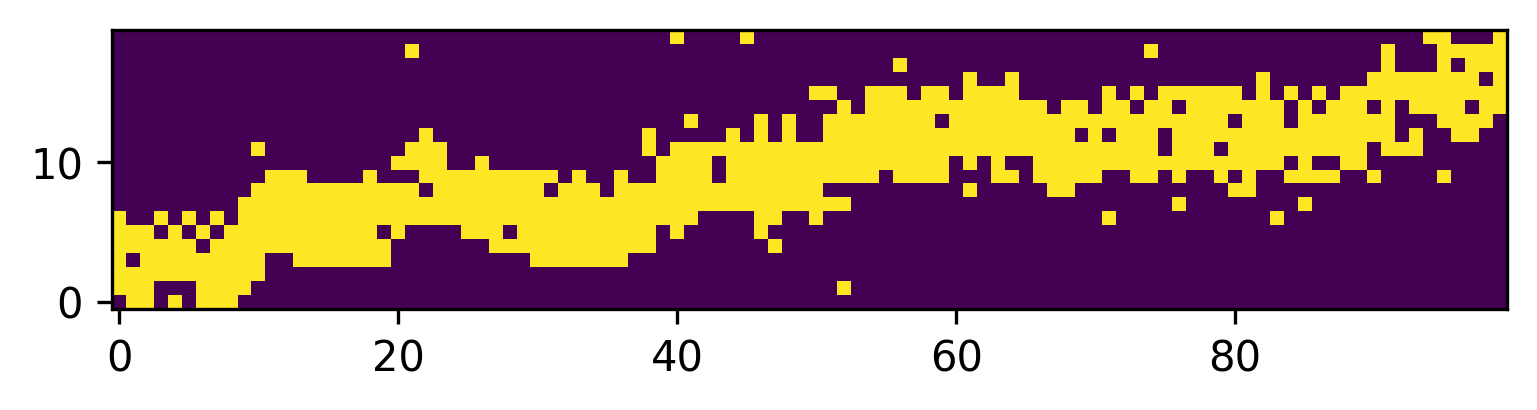

In [5]:
# Now: visualize the typical samples generated (from some starting point)
# run several times to continue this. It basically is a random walk
# through the space of all possible configurations, hopefully according
# to the probability distribution that has been trained!

nsteps=100
test_samples=np.zeros([num_visible,nsteps])

v_prime=np.zeros(num_visible)
h=np.zeros(num_hidden)
h_prime=np.zeros(num_hidden)

for j in range(nsteps):
    v,h,v_prime,h_prime=BoltzmannSequence(v,a,b,w,drop_h_prime=True) # step from v via h to v_prime!
    test_samples[:,j]=v[0,:]
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(test_samples,origin='lower',interpolation='none')
        plt.show()

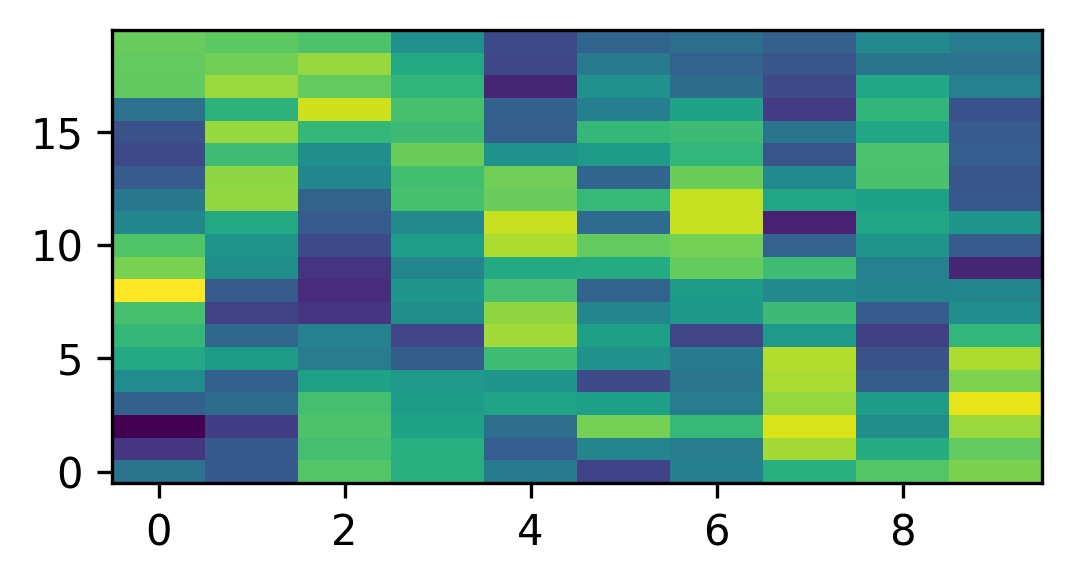

In [6]:
# Now show the weight matrix

plt.figure(figsize=(0.2*num_visible,0.2*num_hidden))
plt.imshow(w,origin='lower',aspect='auto')
plt.show()

# Tutorial: train on differently shaped samples (e.g. a bar with both random position and random width)

...or two bars, located always at the same distance!

# Homework: train on MNIST images!

Here the visible units must be a flattened version of the images, something like

v=np.reshape(image,[batchsize,widh*height])

...if image is of shape [batchsize,width,height], meaning an array holding the pixel values for all images in a batch!

...to plot the results, you would use 

np.reshape(v,[batchsize,width,height])

to get back to the image format!